In [65]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Řešení kontaktní úlohy 2D průhybu membrány
V této úloze se pokusíme vyřešit kontaktní úlohu
\begin{align*}
    -\Delta u &= f(x,y)\:\:\mathrm{na}\:\:\Omega\subset\mathbb{R}^2,\\
    u &= 0\:\:\mathrm{na}\:\:\Gamma_D,\\
    \frac{du}{dn} &= h(x,y)\:\:\mathrm{na}\:\:\Gamma_N,\\
    u - g &\geq 0\:\:\mathrm{na}\:\:\Gamma_C, \\
    \frac{du}{dn}&\geq 0\:\:\mathrm{na}\:\:\Gamma_C, \\
    \frac{du}{dn}(u-g) &= 0\:\:\mathrm{na}\:\:\Gamma_C,
\end{align*}
kde 
$g(x,y)=\sqrt{\frac{1}{2}-x^2}-\frac{\sqrt{2}}{2}-\frac{3}{5}$, $f(x,y)=-1$, $h(x,y)=0$.
Zovlíme oblast $\Omega$ jako čtverec:
\begin{align*}
\Omega=\{(x,y)\in\mathbb{R}^2:\:|x|<1\:\wedge\: |y|<1\},
\end{align*}
a hranice, na nichž definujeme Dirichletovu, Neumannovu a kontaktní podmínky, zvolíme jako 
\begin{align*}
    \Gamma_D &= \{(x,y)\in\partial \Omega:\:y=1\},\\
    \Gamma_N &= \{(x,y)\in\partial \Omega:\:|x|=1\},\\
    \Gamma_C &= \{(x,y)\in\partial \Omega:\:y=-1\}.
\end{align*}

Tato úloha popisuje situaci průhybu čtvercové membrány.

Použijeme neuonovou síť s 5 skrytými vrstvami se 20 neurony s aktivační funkcí $tanh()$ v každé vrstvě.

Tento skript obsahuje také formulace obdobné úlohy:
- s výhradně Dirichletovou podmínkou na celé hranici $\partial\Omega$,
- s Dirichletovou podmínkou na hranici $\Gamma_D$ a s Neumannovou podmínkou na hranici $\Gamma_N \cup \Gamma_C$.

Tyto modifikace jsou ve skriptu zahrnuty z důvodu ověření správnosti fungování NN. Zadání jsou zvolena dle konkrétního řešení, můžeme tedy spočítat relativní chybu aproximace NN. Úloha s Dirichletovou a Neumannovou podmínkou byla také použita pro testování vlivu struktury a množství trénovacích dat na přesnost aproximace řešení NN.

Neuronová síť má následující vlastnosti:
- dva vstupní neurony (řešíme úlohu ve 2D),
- 5 skrytých vrstev s 20 neurony používajícími aktivační funkci $tanh()$,
- jeden výstupní neuron.

Proces definice, učení a testování neuronové sítě je rozdělen do několika kroků:

**Krok 0:**
Definujeme globální proměnnou `PROBLEM_TYPE`, která určuje, jakou úlohu chceme řešit:
- `dirichlet`: úloha $-\Delta u = -2\:\:\mathrm{na}\:\:\Omega$ s Dirichletovou podmínkou $u=\frac{x^2}{2}+\frac{y^2}{2}\:\:\mathrm{na}\:\:\partial\Omega$
- `dirichlet+neumann`: úloha $-\Delta u = -2\:\:\mathrm{na}\:\:\Omega$ s Dirichletovou podmínkou $u=g_D=\frac{x^2}{2}+\frac{y^2}{2}+3xy+\frac{1}{3}\:\:\mathrm{na}\:\:\Gamma_D$ a Neumannovou podmínkou $\frac{du}{dn}=\frac{dg_D}{dn}\:\:\mathrm{na}\:\:\Gamma_N\cup\Gamma_C$
- `contact`: kontaktní úloha uvedena výše

**Krok 1:**
Definujeme architekturu neuronové sítě.
Vytvoříme pomocné funkce:
- `generate_inner_train_data()` pro vygeneování trénovacích dat uvnitř oblasti $\Omega$,
- `generate_boundaries()` pro vygenerování trénovacích dat na hranici oblasti $\Omega$ (vynecháme body v rozích oblasti z důvodu absence derivace),
- `plot_boundaries()` pro vykreslení bodů, na kterých budeme NN trénovat (body na hranici i uvnitř oblasti $\Omega$),
- `compute_derivatives_2d()`, která počítá první a druhé derivace s využitím utility `autograd.grad` z knihovny `PyTorch`,
- `compute_normal_derivative()`, která počítá normálovou derivaci $\frac{du}{dn}$,
- `f_function()`, `g_function()`, `h_function()`, které odpovídají funkcím $f(x,y)$, $g(x,y)$ a $h(x,y)$ ze zadání úlohy (případně $g_D$ ze zadání úlohy dirichlet+neumann).

**Krok 2:** 
Definujeme funkci `compute_loss()`, ve které je spočtena každá dílčí ztrátová funkce odpovídající každé rovnici ze zadání úlohy. Tyto ztrátové funkce jsou poté sečteny.

**Krok 3:**
Vygenerujeme 2000 rovnoměrně rozložených tréninkových bodů uvnitř oblasti $\Omega$ a 50 rovnoměrně rozložených bodů na hranici oblasti $\Omega$.

**Krok 4:**
Tréninková data převedeme do `DataLoader` pro učení v dávkách. Zvolíme velikost dávky 64. Inicializujeme neuronovou síť a nastavíme optimalizátor Adam s mírou učení $10^{-3}$.

**Krok 5:**
Spustíme smyčku pro učení NN na 2000 epoch. Vykreslíme graf znázorňující závislost ztráty na počtu epoch.

**Krok 6:**
Vygenerujeme 2000 náhodně rozložených testovacích bodů a vyhodnotíme model na testovacích datech.
Vykreslíme přesné řešení úlohy.
V případě okrajové podmínky neznáme přesné řešení, ale výsledná vizualizace odpovídá fyzikální interpretaci zadané úlohy. V případě modifikaci úlohy pro pouze Dirichletovu nebo Dirichletovu a Neumannovu podmínku můžeme vypočíst relativní chybu aproximace NN.

In [66]:
# Krok 0: Výběr typu úlohy
# Možnosti: "dirichlet", "dirichlet+neumann", "contact"
PROBLEM_TYPE =  "contact"

In [67]:
# Krok 1.1: Definice modelu neuronové sítě 
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(2, 20)  # Vstup je 2D, proto 2 vstupy (x,y)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(20, 20)
        self.tanh2 = nn.Tanh()
        self.fc3 = nn.Linear(20, 20)
        self.tanh3 = nn.Tanh()
        self.fc4 = nn.Linear(20, 20)
        self.tanh4 = nn.Tanh()
        self.fc5 = nn.Linear(20, 20)
        self.tanh5 = nn.Tanh()
        self.fc6 = nn.Linear(20, 1)  # Výstup je skalár u(x,y)

    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh1(x)
        x = self.fc2(x)
        x = self.tanh2(x)
        x = self.fc3(x)
        x = self.tanh3(x)
        x = self.fc4(x)
        x = self.tanh4(x)
        x = self.fc5(x)
        x = self.tanh5(x)
        x = self.fc6(x)
        return x

In [68]:
# Krok 1.2: Funkce pro generování rovnoměrně rozložených trénovacích dat
def generate_inner_train_data(no_points): # Body uvnitř oblasti
    x = torch.linspace(-1, 1, int(torch.sqrt(torch.tensor(no_points)))) 
    y = torch.linspace(-1, 1, int(torch.sqrt(torch.tensor(no_points)))) 
    X, Y = torch.meshgrid(x, y)

    x = X.reshape(-1, 1)
    y = Y.reshape(-1, 1)
    
    points_in = (torch.abs(x) < 1 - 1e-3) & (torch.abs(y) < 1 - 1e-3)

    x_train = x[points_in].view(-1, 1)
    y_train = y[points_in].view(-1, 1)

    return (x_train, y_train)

def generate_boundaries(no_points): # Body na hranici
    # Definice Dirichletovy hranice
    x_dirichlet = torch.linspace(-1,1, no_points).view(-1, 1)
    y_dirichlet = torch.ones_like(x_dirichlet)
    # Definice Neumannovy hranice
    y_neumann_left = torch.linspace(-1, 1, no_points+2).view(-1, 1)[1:-1] # Odstranění rohových bodů kvůli neexistující derivaci
    x_neumann_left = -torch.ones_like(y_neumann_left)
    y_neumann_right = torch.linspace(-1, 1, no_points+2).view(-1, 1)[1:-1] # Odstranění rohových bodů kvůli neexistující derivaci
    x_neumann_right = torch.ones_like(y_neumann_right)
    # Definice kontaktní hranice
    x_contact = torch.linspace(-1,1, no_points+2).view(-1, 1)[1:-1] # Odstranění rohových bodů kvůli neexistující derivaci
    y_contact = -torch.ones_like(x_contact)

    return (x_dirichlet, y_dirichlet, x_neumann_left, y_neumann_left, x_neumann_right, y_neumann_right, x_contact, y_contact)

In [69]:
# Krok 1.2: Funkce pro vykreslení trénovacích bodů
def plot_boundaries(x_train, y_train, x_dirichlet, y_dirichlet, x_neumann, y_neumann, x_contact, y_contact):
    plt.figure(figsize=(6, 6))
    plt.scatter(x_dirichlet.numpy(), y_dirichlet.numpy(), label="Dirichlet",s=5, color='blue')
    plt.scatter(x_contact.numpy(), y_contact.numpy(), label="Kontakt",s=5, color='green')
    plt.scatter(x_neumann.numpy(), y_neumann.numpy(), label="Neumann",s=5, color='red')
    plt.scatter(x_train.numpy(), y_train.numpy(), label="Trénovací data",s=10, color='yellow')
    plt.axhline(0, color='black',linewidth=1)
    plt.axvline(0, color='black',linewidth=1)
    plt.title("Hranice")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    return

In [70]:
# Krok 1.3: Funkce pro výpočet derivací
def compute_derivatives_2d(model, x, y): # Výpočet derivací pomocí funkce autograd z knihovny PyTorch
    inputs = torch.hstack((x,y)).requires_grad_(True)
    u = model(inputs)
    
    # První derivace
    u_x = grad(u, inputs, torch.ones_like(u), create_graph=True)[0][:, 0:1]  # du/dx
    u_y = grad(u, inputs, torch.ones_like(u), create_graph=True)[0][:, 1:2]  # du/dy
    
    # Druhé derivace
    u_xx = grad(u_x, inputs, torch.ones_like(u_x), create_graph=True)[0][:, 0:1]  # d²u/dx²
    u_yy = grad(u_y, inputs, torch.ones_like(u_y), create_graph=True)[0][:, 1:2]  # d²u/dy²

    du = torch.autograd.grad(torch.sum(u), inputs, create_graph=True)[0] # Gradient
    
    return (u, u_x, u_y, u_xx, u_yy, du)

def compute_normal_derivative(du, x, y): # Výpočet normálové derivace du/dn
    du_x = du[:, 0].reshape(-1, 1)  
    du_y = du[:, 1].reshape(-1, 1)  
    dudn = torch.zeros_like(du_x)
    dudn = torch.where(x.view(-1, 1) == -1, -du_x, dudn) # Levá hranice
    dudn = torch.where(x.view(-1, 1) == 1, du_x, dudn)   # Pravá hranice
    dudn = torch.where(y.view(-1, 1) == -1, -du_y, dudn) # Spodní hranice
    dudn = torch.where(y.view(-1, 1) == 1, du_y, dudn)   # Horní hranice
    return dudn

In [71]:
# Krok 1.3: Funkce v zadání úlohy
def f_function(condition_type):
   if condition_type=="contact":
      return -1
   else:
      return -2
   
def g_function(x,y,condition_type):
   if condition_type=="dirichlet":
      return (x**2)/2+(y**2)/2
   elif condition_type=="dirichlet+neumann":
      return (x**2)/2+(y**2)/2+3*x*y+1/3
   elif condition_type=="contact": # V tomto případě je g_function funkce určující kontaktní hranici
      return torch.sqrt(torch.clamp(0.5 - x**2, 0, None)) - torch.sqrt(torch.tensor(2.0)) / 2 - 0.6

def h_function(x_left, x_right, x_bottom, y_left, y_right, y_bottom):
   return torch.vstack((-x_left-3*y_left, x_right+3*y_right, -3*x_bottom-y_bottom))


In [72]:
# Krok 2: Definice ztrátové funkce
def compute_loss(model, x_train, y_train, x_dirichlet, y_dirichlet, x_neumann_left, y_neumann_left, x_neumann_right, y_neumann_right, x_contact, y_contact, condition_type):
    if condition_type=="dirichlet":
        x_neumann = torch.cat([x_neumann_left, x_neumann_right], dim=0)
        y_neumann = torch.cat([y_neumann_left, y_neumann_right], dim=0)
        x_dirichlet_boundary = torch.cat([x_dirichlet, x_neumann, x_contact], dim=0) # Dirichletovu podmínku vynucujeme na celé hranici
        y_dirichlet_boundary = torch.cat([y_dirichlet, y_neumann, y_contact], dim=0) # Dirichletovu podmínku vynucujeme na celé hranici

        # PDR ztráta (-Δu = f)
        _, _, _, u_xx_train, u_yy_train, _ = compute_derivatives_2d(model, x_train, y_train) # Výpočet derivací
        pde_loss = torch.mean((-(u_xx_train + u_yy_train) - f_function(condition_type))**2)
        
        # Ztráta na Dirichletově hranici (u = g na \delta\Omega)
        u_dirichlet = model(torch.cat([x_dirichlet_boundary, y_dirichlet_boundary], dim=1))
        dirichlet_loss = torch.mean((u_dirichlet - g_function(x_dirichlet_boundary, y_dirichlet_boundary, condition_type))**2)

        # Celková ztráta
        total_loss = pde_loss + dirichlet_loss
        return total_loss
    
    elif condition_type=="dirichlet+neumann":
        x_neumann_boundary = torch.cat([x_neumann_left, x_neumann_right, x_contact], dim=0) # Neumannovu podmínku vynucujeme na celé hranici kromě Dirichletovy
        y_neumann_boundary = torch.cat([y_neumann_left, y_neumann_right, y_contact], dim=0) # Neumannovu podmínku vynucujeme na celé hranici kromě Dirichletovy

        # PDR ztráta (-Δu = f)
        _, _, _, u_xx_train, u_yy_train, _ = compute_derivatives_2d(model, x_train, y_train) # Výpočet derivací
        pde_loss = torch.mean((-(u_xx_train + u_yy_train) - f_function(condition_type))**2)

        # Ztráta na Dirichletově hranici (u = g na \Gamma_D)
        u_dirichlet = model(torch.cat([x_dirichlet, y_dirichlet], dim=1))
        dirichlet_loss = torch.mean((u_dirichlet - g_function(x_dirichlet, y_dirichlet, condition_type))**2)

        # Ztráta na Neumannově hranici (du/dn = h na \Gamma_N\cup\Gamma_C)
        _, _, _, _, _, du_neumann = compute_derivatives_2d(model, x_neumann_boundary, y_neumann_boundary)
        u_n_neumann = compute_normal_derivative(du_neumann, x_neumann_boundary, y_neumann_boundary)

        neumann_loss = torch.mean((u_n_neumann-h_function(x_neumann_left, x_neumann_right, x_contact, y_neumann_left, y_neumann_right, y_contact))**2)

        # Celková ztráta
        total_loss = pde_loss + dirichlet_loss + neumann_loss
        return total_loss
    
    elif condition_type=="contact":
        x_neumann = torch.cat([x_neumann_left, x_neumann_right], dim=0)
        y_neumann = torch.cat([y_neumann_left, y_neumann_right], dim=0)
        # PDR ztráta (-Δu = -1)
        _, _, _, u_xx_train, u_yy_train, _ = compute_derivatives_2d(model, x_train, y_train) # Výpočet derivací
        pde_loss = torch.mean((-(u_xx_train + u_yy_train) - f_function(condition_type))**2)
        
        # Ztráta na Dirichletově hranici (u = 0 na \Gamma_D)
        u_dirichlet = model(torch.cat([x_dirichlet, y_dirichlet], dim=1))
        dirichlet_loss = torch.mean((u_dirichlet)**2)

        # Ztráta na Neumannově hranici (du/dn = 0 na \Gamma_N)
        _, _, _, _, _, du_neumann = compute_derivatives_2d(model, x_neumann, y_neumann)
        u_n_neumann = compute_normal_derivative(du_neumann, x_neumann, y_neumann)
        neumann_loss = torch.mean((u_n_neumann)**2)

        # Ztráta na kontaktní hranici \Gamma_C
        u_contact, _, _, _, _, du_contact = compute_derivatives_2d(model, x_contact, y_contact)
        g_contact = g_function(x_contact, y_contact, condition_type)
        u_n_contact = compute_normal_derivative(du_contact, x_contact, y_contact)
        contact_loss_1 = torch.mean((torch.relu(g_contact-u_contact))**2)  # u(x) >= g
        contact_loss_2 = torch.mean((torch.relu(-u_n_contact))**2)  # du/dn >= 0
        contact_loss_3 = torch.mean(((u_contact - g_contact) * u_n_contact)**2)  # (u-g)du/dn = 0
        
        contact_loss = contact_loss_1 + contact_loss_2 + contact_loss_3

        # Celková ztráta
        total_loss = pde_loss + dirichlet_loss + neumann_loss + contact_loss
        
        return total_loss
        

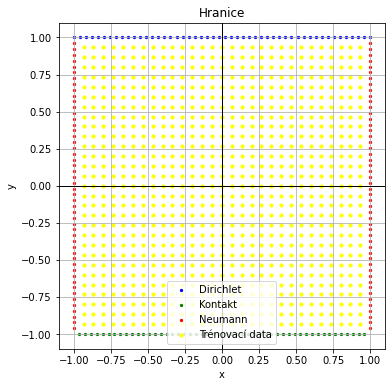

In [73]:
# Krok 3: Vygenerování trénovacích dat
x_train, y_train = generate_inner_train_data(1000) # Body uvnitř oblasti
x_dirichlet, y_dirichlet, x_neumann_left, y_neumann_left,x_neumann_right, y_neumann_right, x_contact, y_contact = generate_boundaries(50) # Body na hranici oblasti
x_neumann = torch.cat([x_neumann_left, x_neumann_right], dim=0)
y_neumann = torch.cat([y_neumann_left, y_neumann_right], dim=0)

plot_boundaries(x_train, y_train, x_dirichlet, y_dirichlet, x_neumann, y_neumann, x_contact, y_contact) # Vykreslení trénovacích dat

In [74]:
# Krok 4: Inicializace modelu a optimalizátoru
dataset_train = TensorDataset(x_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True) # DataLoader pro učení po dávkách

model = MyModel()
optimizer = optim.Adam(model.parameters(), lr=1e-3) 

In [75]:
# Krok 5.1: Trénovací smyčka
loss_values = [] # Seznam pro ukládání ztráty v každé epoše
epochs = 2000
for epoch in range(epochs):
    epoch_loss = 0.0
    for batch_idx, (batch_x_train, batch_y_train) in enumerate(dataloader_train):
        optimizer.zero_grad()
        
        # Výpočet ztráty
        loss = compute_loss(model, batch_x_train, batch_y_train, x_dirichlet, y_dirichlet, x_neumann_left, y_neumann_left, x_neumann_right, y_neumann_right, x_contact, y_contact, PROBLEM_TYPE)

        loss.backward() # Backward pass
        optimizer.step() # Optimalizace

        epoch_loss += loss.item()
    loss_values.append(epoch_loss)

    if (epoch + 1) % 100 == 0:
        print(f'Epocha {epoch+1}/{epochs}, Ztráta: {loss.item()}')

Epocha 100/2000, Ztráta: 0.009230962023139
Epocha 200/2000, Ztráta: 0.002291959710419178
Epocha 300/2000, Ztráta: 0.0009743911796249449
Epocha 400/2000, Ztráta: 0.0007696928805671632
Epocha 500/2000, Ztráta: 0.0009326089639216661
Epocha 600/2000, Ztráta: 0.0007502250955440104
Epocha 700/2000, Ztráta: 0.0011198337888345122
Epocha 800/2000, Ztráta: 0.0018052132800221443
Epocha 900/2000, Ztráta: 0.0008500042604282498
Epocha 1000/2000, Ztráta: 0.0007288310443982482
Epocha 1100/2000, Ztráta: 0.0005540670244954526
Epocha 1200/2000, Ztráta: 0.0006376280798576772
Epocha 1300/2000, Ztráta: 0.0005477621452882886
Epocha 1400/2000, Ztráta: 0.00048646744107827544
Epocha 1500/2000, Ztráta: 0.0005197983118705451
Epocha 1600/2000, Ztráta: 0.0004777081194333732
Epocha 1700/2000, Ztráta: 0.000752276973798871
Epocha 1800/2000, Ztráta: 0.0007402398041449487
Epocha 1900/2000, Ztráta: 0.00043456529965624213
Epocha 2000/2000, Ztráta: 0.0007067652186378837


Nejlepší epocha 1934, Ztráta: 0.0057991692156065255


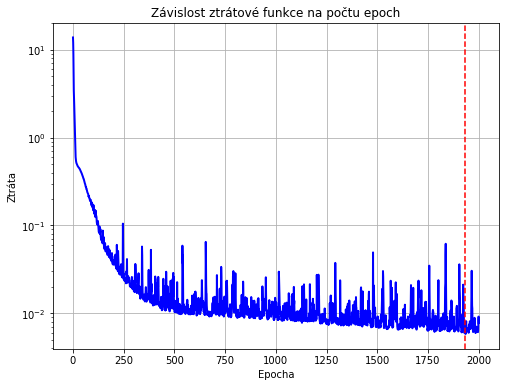

In [76]:
# Krok 5.2: Graf znázorňující závislost ztráty na počtu epoch
best_epoch = min(loss_values)
best_epoch_idx = loss_values.index(best_epoch)
print(f'Nejlepší epocha {best_epoch_idx}, Ztráta: {best_epoch}')

plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), loss_values, color='blue', linewidth=2)
plt.axvline(best_epoch_idx, color='r', linestyle='--', label='Nejlepší epocha')
plt.yscale('log')
plt.title('Závislost ztrátové funkce na počtu epoch')
plt.xlabel('Epocha')
plt.ylabel('Ztráta')
plt.grid(True)
plt.show()

In [77]:
# Krok 6.1: Funkce pro vygenerování testovacích dat v oblasti Omega (i na její hranici)
def generate_test_data(no_points):
    x = torch.rand(no_points, 1) * 2 - 1 
    y = torch.rand(no_points, 1) * 2 - 1
    points_in = (torch.abs(x) <= 1) & (torch.abs(y) <= 1)
    x_test = x[points_in].view(-1, 1)
    y_test = y[points_in].view(-1, 1)

    return (x_test, y_test)

In [78]:
# Krok 6.2: Vygenerování testovacích dat a otestování NN
x_test, y_test = generate_test_data(3000)

with torch.no_grad():
    inputs = torch.cat([x_test, y_test], dim=1)
    u_pred = model(inputs) 

u_pred_np = u_pred.numpy()

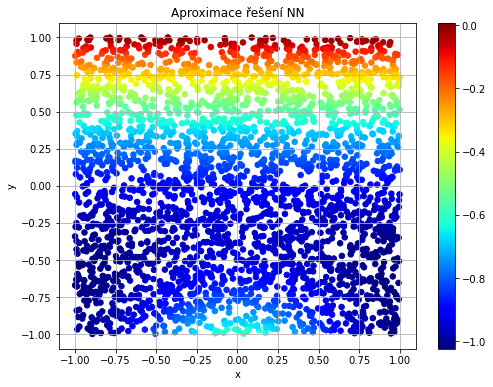

In [79]:
# Krok 6.3: Vykreslení aproximace NN řešení zadané úlohy
plt.figure(figsize=(8, 6))
plt.scatter(x_test.numpy(), y_test.numpy(), c=u_pred_np, cmap='jet', s=30)
plt.colorbar()
plt.title('Aproximace řešení NN')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

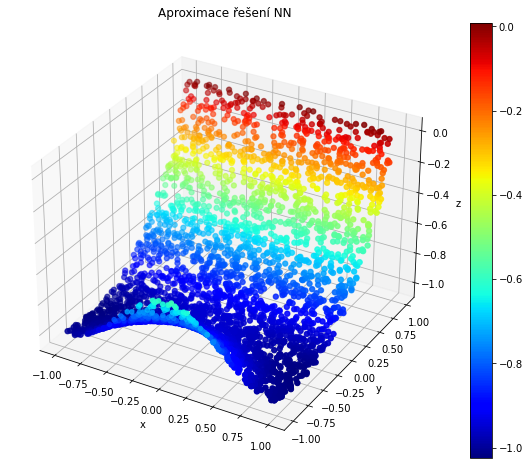

In [80]:
# Krok 6.4: Vykreslení aproximace NN řešení zadané úlohy ve 3D grafu
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_test.numpy(), y_test.numpy(), u_pred_np, c=u_pred_np, cmap='jet', s=30)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Aproximace řešení NN')
cbar = plt.colorbar(ax.scatter(x_test.numpy(), y_test.numpy(), u_pred_np, c=u_pred_np, cmap='jet', s=20), ax=ax)
plt.show()

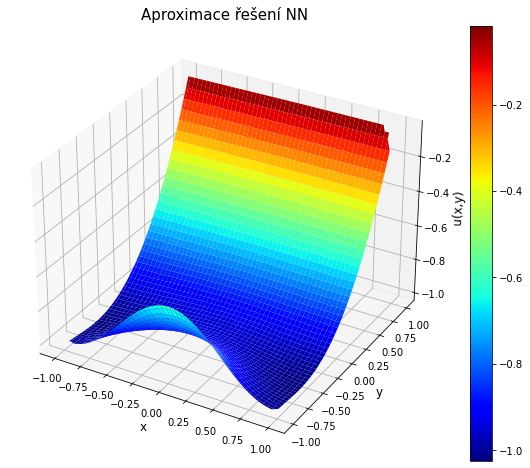

In [81]:
# Krok 6.5: Vykreslení aproximace NN řešení zadané úlohy ve 3D grafu s využitím interpolace
x = x_test.numpy().flatten()
y = y_test.numpy().flatten()
z = u_pred_np.flatten()

# Vystvoření mřížky
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(xi, yi)

# Interpolace
Z = griddata((x, y), z, (X, Y), method='cubic')

# Vykreslení
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='jet', edgecolor='none')

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_zlabel('u(x,y)', fontsize=12)
ax.set_title('Aproximace řešení NN', fontsize=15)

cbar = plt.colorbar(surf, ax=ax)

plt.show()

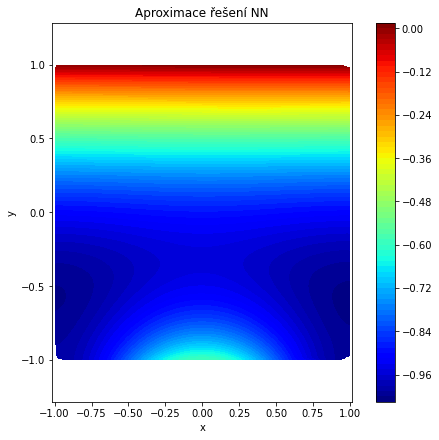

In [82]:
# Krok 6.6: Vykreslení aproximace NN řešení zadané úlohy ve 2D grafu s interpolací
x_test, y_test = generate_test_data(15000)

with torch.no_grad():
    inputs = torch.cat([x_test, y_test], dim=1)
    u_pred = model(inputs) 

# Interpolace
fig, axes = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)

x = x_test.detach().cpu().numpy().squeeze()
y = y_test.detach().cpu().numpy().squeeze()

z = u_pred.detach().cpu().numpy().squeeze()

grid_x, grid_y = np.linspace(-1, 1, 500), np.linspace(-1, 1, 500)
grid_x, grid_y = np.meshgrid(grid_x, grid_y)

grid_z = griddata((x, y), z, (grid_x, grid_y), method="linear")

# Vykreslení
ax = axes
im = ax.contourf(grid_x, grid_y, grid_z, levels=100, cmap="jet", vmin=None, vmax=None)
fig.colorbar(im, ax=ax, orientation="vertical")
ax.set_title("Aproximace řešení NN")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.axis("equal")
plt.show()

In [83]:
# Krok 6.7: V případě upravené úlohy provedeme výpočet relativní chyby aproximace řešení NN
if PROBLEM_TYPE=="dirichlet": # Výpočet relativní chyby Dirichletovy úlohy
    true_values_dirichlet = g_function(x_test, y_test, PROBLEM_TYPE)
    error_norm = torch.norm(u_pred - true_values_dirichlet)
    true_norm = torch.norm(true_values_dirichlet)
    relative_error = error_norm / true_norm
    print(f'Relativní chyba úlohy s pouze Dirichletovou podmínkou: {relative_error.item():.4f}')

if PROBLEM_TYPE=="dirichlet+neumann": # Výpočet relativní chyby Dirichlet+Neumann úlohy
    true_values_dirichlet_neumann = g_function(x_test, y_test, PROBLEM_TYPE)

    error_norm = torch.norm(u_pred - true_values_dirichlet_neumann)
    true_norm = torch.norm(true_values_dirichlet_neumann)
    relative_error = error_norm / true_norm
    print(f'Relativní chyba úlohy s Dirichletovou a Neumannovou podmínkou: {relative_error.item():.4f}')